This is the documentation for the janeliasig module.

Unpacking Binary Files
-----


This takes the binary files and converts them into plottable numpy arrays. The binary file will usually be in int-byte8 characters. I load 50E6 bytes at a time; the computer will crash if the binary files are loaded all at once.

The graph below is an example of a graph plotted from binary files. I just loaded 1000 data points for graphing (Highly recommended: otherwise, the computer will crash).

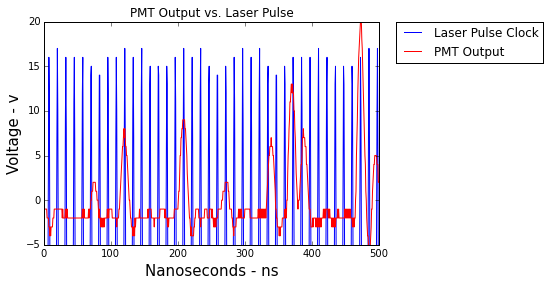

In [2]:
import janeliasig.algorithm as js
import numpy as np
import matplotlib.pyplot as plt
import os

#1.5 gigahertz laser pulse
#converted to nanoseconds

warnings.filterwarnings("ignore", category=DeprecationWarning)
Location =  os.path.normpath("//tier2/svoboda/fastDAQ_GeorgKarel/measurements on dye/")

#Loading one file at a time
#PMT Output
fn_photons = '\\' + "0024_3_ch0.bin" #PMT output
filename = Location + fn_photons
photons = js.load_raw_data(filename, 10e3)


#Laser clock file
fn_laser = '\\' + "0029_1_ch1.bin" #Laser Clock
filename2 = Location + fn_laser
laser = js.load_raw_data(filename2, 10e3)

fig = plt.figure()
ax= fig.add_subplot(111)

#Multiplying the x-axis by 2/3 to switch to time
plt.plot(np.linspace(0, len(laser) * (2.0/3.0), len(laser)), laser, 'b-', label = "Laser Pulse Clock")
plt.plot(np.linspace(0, len(photons) * (2.0/3.0), len(photons)),photons, 'r-', label = "PMT Output")



plt.xlabel('Nanoseconds - ns', fontsize = 15)
plt.ylabel('Voltage - v', fontsize = 15)
ax.set_title("PMT Output vs. Laser Pulse")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#Uncomment these three lines if you want to change the interval of the x range
#ax.set_xticks(np.arange(0, len(photons) * (2.0/3.0), 100))
#ax.set_xticklabels(np.arange(0, len(photons) * (2.0/3.0), 100))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.xlim(0, 500)
plt.ylim(-5, 20)
plt.show()



File "0026" is from the Svoboda preamp while file "0036" is from the ThorLabs preamp. Channel 0 is the laser output while channel 1 is the photon emittance from fluorescent solution. Note how my directory used "/" with os.path as a trick (string literals were being an annoyance) 


I also created "gui_browser.py" for a more interactive GUI. Look at "README" to use it.

Poisson Simulation
---

Just basic poisson distribution graphs. Also, it should be important to note that poisson-modulated arrivals are modeled by exponential variation.

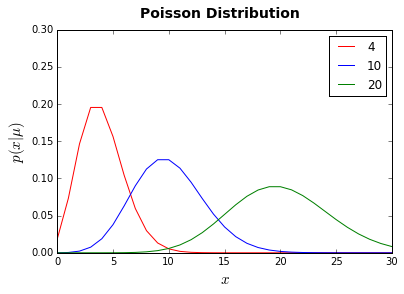

In [4]:
lambdas = [4, 10, 20]
colors = ['r-', 'b-', 'g-']

fig = plt.figure()
fig.suptitle('Poisson Distribution', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)

for mu, ls in zip(lambdas, colors):
    dist = stats.poisson(mu)
    x = np.arange(0, 50)
    
    plt.plot(x, dist.pmf(x), ls, label = str(mu))
plt.xlim(0, 30)
plt.ylim(0, 0.3)

plt.xlabel('$x$', fontsize = 15)
plt.ylabel(r'$p(x|\mu)$', fontsize = 15)


plt.legend(loc = "upper right")
plt.show()

First basic poisson arrival time points. This bit of code was used to create the poisson function.

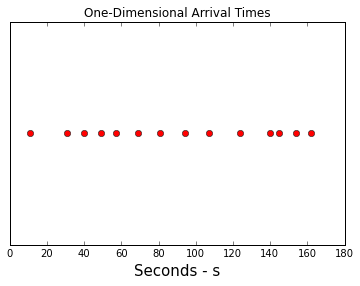

In [5]:

ax = fig.add_subplot(111)
ax.set_ylim(0, 1)

time = 0
for i in range(1,15):
    time += np.random.poisson(10)
    #print t
    plt.plot(time , 0, 'ro', label = "Arrivals" ) 
ax = plt.gca()
plt.xlabel('Seconds - s', fontsize = 15)
ax.set_title("One-Dimensional Arrival Times")
ax.yaxis.set_visible(False)

Poisson (function)
---
Self-explanatory. Note how I used random.expovariate. Also, this only provides the arrival times (not inter-arrival times). Interarrival times can be modeled with the poisson_interarrival() function.

Poisson processes are defined to have a mean (expected value) equivalent to the variance. Therefore, I check my poisson simulations with a mean-variance graph (expected slope of 1). Statistics() funtion calculates mean, variance, and standard error (for error bars). Functions like rsquared() and lin_fit() were created to help with the analysis of the slope. 

Because of the hundreds of thousands of data points that the simulation uses, it took up quite a time. Time() was used to track the duration of the simulation. To create a mean-variance graph, multiple expected values (mean) ran through the full_simulation() function.

In [67]:
start_time = time.time()
expected_values = [1, 5, 10, 15, 20, 25, 30]
plot_mean = []
plot_variance = []
std_error = []
for mean in expected_values:
    temp_data = js.mean-variance-poisson(mean, 20000, 10)
    plot_mean.append(temp_data[0])
    plot_variance.append(temp_data[1])
    std_error.append(temp_data[2])

plot_mean.insert(0, 0)
plot_variance.insert(0, 0)
std_error.insert(0, 0)

print("----%s seconds ---" % (time.time() - start_time))

----3.63700008392 seconds ---


To check that the poisson process is running correctly, mean-varance graph was plotted. If the process was truly poisson-modulated, then the mean will equal the variance. 

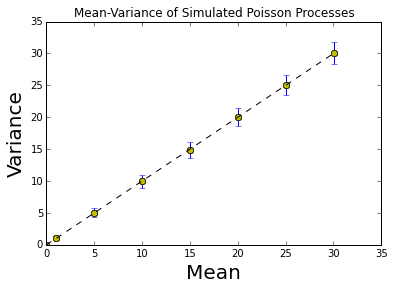

Slope: 1.00272721398
R-Squared: 0.999964716772
Error Bars: [0, 0.316, 0.709, 0.999, 1.22, 1.415, 1.584, 1.736]


In [68]:
error = std_error

fig = plt.figure()
ax = fig.add_subplot(111)
plt.errorbar(plot_mean, plot_variance, yerr= error, fmt = 'o')
plt.plot(plot_mean, plot_variance, 'ro')
fit = np.polyfit(plot_mean,plot_variance,1)
fit_fn = np.poly1d(fit) 

plt.plot(plot_mean,plot_variance, 'yo', plot_mean, plot_mean , '--k')
plt.xlabel('Mean', fontsize = 20)
plt.ylabel('Variance', fontsize = 20)
ax.set_title("Mean-Variance of Simulated Poisson Processes")
(m, b) = np.polyfit(plot_mean, plot_variance, 1)

plt.show()
print "Slope: " + str(m)
print "R-Squared: " + str(rsquared(plot_mean, plot_variance))
print "Error Bars: " + str(error)

Discreet Time Series to Gaussian Curves
---
The simulated poisson series were binned. 0 for no photon emittance in that bin, 1 for photon emittance in that bin. The following code produced "subtracted_data", which is just 0's, 1's, and 2's for the frequency of binned data.

In [11]:
additive_data = js.poisson(10, 2000)

intervalsets = np.arange(0, 10, .005, dtype = 'float')
track = []
g = 0

for c in intervalsets:
    for i in additive_data:
        if i <= c:
            g += 1
    track.append(g)
    g = 0


additive_data = [track[0]]
for b in range(0, len(track) - 1):
    additive_data.append(track[b+1] - track[b])
    
print additive_data

#Nick suggested that I multiply the noise factor before convolution

multiplicative_noise = np.random.normal(0, 15, 2000) * 2
multiplicative_data = abs(multiplicative_noise) * additive_data


[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

A Gaussian Kernel was created to convolve the discreet time-series. To make it accurate as possible, 401 points were used in the kernel. The Gaussian's standard deviation was 1 sigma (this will be important in the future). 

In [12]:
gaussian_kernel = js.gaussian_kernel(3)
print gaussian_kernel

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0913910116633136e-320, 3.6574035066499041e-315, 1.0967530306911314e-309, 2.9429973223913704e-304, 7.0666885050820196e-299, 1.5184031192324406e-293, 2.9194650716474492e-288, 5.0230157254013151e-283, 7.7334066836699092e-278, 1.0654233695758118e-272, 1.313465425712008e-267, 1.4489724552642385e-262, 1.4303643309474773e-257, 1.263508800030956e-252, 9.9874571271101453e-248, 7.064422134810288e-243, 4.4713988911647875e-238, 2.5325337661583525e-233, 1.2835480515691283e-228, 5.8212208558625898e-224, 2.3624415868430925e-219, 8.579325376475667e-215, 2.7879838686188211e-210, 8.1

The kernel was then used to convolve the signal. The numpy.convolve() parameter was set as "full" because "same" misaligned the signal.

(0, 1)

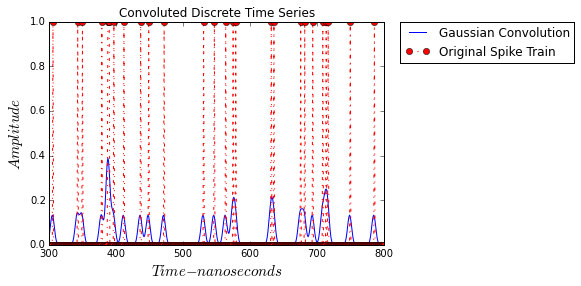

In [13]:
convoluted_data_additive = np.convolve(gaussian_kernel, additive_data, 'full')
convoluted_data_additive = convoluted_data_additive[len(gaussian_kernel)/2 + 1: -len(gaussian_kernel)/2]

convoluted_data_multiplicative = np.convolve(gaussian_kernel, multiplicative_data, 'full')
convoluted_data_multiplicative = convoluted_data_multiplicative[len(gaussian_kernel)/2 + 1: -len(gaussian_kernel)/2]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(convoluted_data_additive, 'b-', label = 'Gaussian Convolution')
ax.plot(additive_data, 'ro-.', label = "Original Spike Train")

plt.xlabel('$Time - nanoseconds$', fontsize = 15)
plt.ylabel('$Amplitude$', fontsize = 15)
ax.set_title("Convoluted Discrete Time Series")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlim(300, 800)
ax.set_ylim(0, 1)


Adding Noise
---
A random set of numbers from a Gaussian distribution was used to introduce noise into the signal. 

From the original data, I noticed the interval of multiplicative noise levels was between 13 - 17. I tried to replicate the signal as similar to the original data as possible (this is why the amplitude went front 0.4 after convolution to ~12 after adding noise). 


Variable naming:

noised_signal = multiplicative noise + additive noise + gaussian scaled to the level of the peaks in the original data

convoluted_data_multiplicative  = gaussian scaled to the level of the peaks in the orignal data

convoluted_data_additive = gaussian convolution without scale

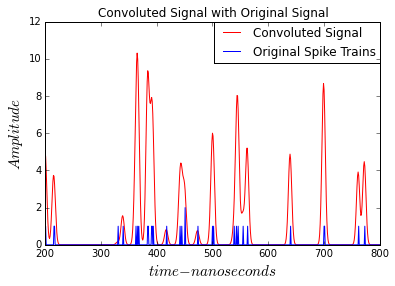

In [146]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(convoluted_data_multiplicative, 'r-', label = "Convoluted Signal")
ax.plot(additive_data, 'b-', label = "Original Spike Trains")

plt.xlabel('$time - nanoseconds$', fontsize = 15)
plt.ylabel('$Amplitude$', fontsize = 15)
ax.set_title("Convoluted Signal with Original Signal")
plt.legend(loc='upper right', borderaxespad=0.)

ax.set_xlim(200, 800)
plt.savefig('Convoluted Signal.eps', format='eps', dpi=1200)

The next step would be multiplicative noise.

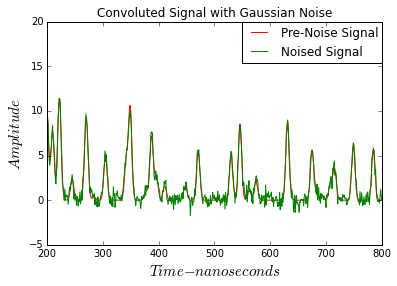

In [14]:

additive_noise = np.random.normal(0, 0.5, len(convoluted_data_multiplicative))
noised_signal = additive_noise +  convoluted_data_multiplicative

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(convoluted_data_multiplicative, 'r-', label = "Pre-Noise Signal")
ax.plot(noised_signal, 'g-', label = "Noised Signal")

plt.xlabel('$Time - nanoseconds$', fontsize = 15)
plt.ylabel('$Amplitude$', fontsize = 15)
ax.set_title("Convoluted Signal with Gaussian Noise")
plt.legend(loc = 'upper right', borderaxespad=0.)

ax.set_xlim(200, 800)
ax.set_ylim(-5, 20)

plt.savefig('Convoluted Signal with Gaussian Noise.eps', format='eps', dpi=1200)

# Threshold Algorithms

Diction:
peaks --> the maxima

valleys --> the minima

In [1]:
#
#Just a presentation of the effectiveness of this algorithm.
series = noised_signal
maxtab, mintab = js.peakdet(series,2.5)
    
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(series, '-')
ax.plot([0, 500], [2.5, 2.5], label = "Threshold", color = "Red")
#these are the peaks of the data
ax.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='green', label = "Peaks")
#these are the vallyes of the data (uncomment)
#ax.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red', label = "Valleys")

plt.xlabel('$Time - nanoseconds$', fontsize = 15)
plt.ylabel('$Amplitude$', fontsize = 15)
ax.set_title("Convoluted Signal with Threshold at 2.5")
plt.legend(loc='upper right', borderaxespad=0.)
ax.set_xlim(0, 400)
ax.set_ylim(0, 15)
    
plt.savefig('Threshold 001.eps', format='eps', dpi=1200)

NameError: name 'noised_signal' is not defined

The following 3 parts of the code prints out the peaks that the algorithm differently

In [159]:
# This uses a built-in scipy command to find the peaks

from scipy import signal
peak_indices = signal.find_peaks_cwt(convoluted_data_multiplicative, np.arange(.5, 10))
print peak_indices

[1, 19, 52, 93, 120, 134, 149, 160, 161, 174, 186, 200, 215, 216, 339, 365, 384, 386, 392, 417, 443, 445, 473, 500, 544, 562, 639, 699, 760, 761, 768, 772, 773, 837, 838, 854, 883, 974, 996, 997, 1028, 1085, 1141, 1142, 1190, 1250, 1293, 1348, 1420, 1452, 1472, 1508, 1537, 1561, 1574, 1614, 1651, 1652, 1693, 1694, 1712, 1760, 1782, 1803, 1804, 1838, 1859, 1861, 1881, 1882, 1896, 1897, 1911, 1924, 1926, 1942, 1962]


In [154]:
#This uses the peakdet() algorithm and the helper method to find the peaks

algorithm_arrival = js.threshold_algorithm(0.1, convoluted_data_multiplicative)
print algorithm_arrival

[0.0, 19.0, 52.0, 93.0, 120.0, 134.0, 149.0, 161.0, 174.0, 186.0, 200.0, 215.0, 339.0, 365.0, 384.0, 391.0, 417.0, 443.0, 473.0, 500.0, 544.0, 562.0, 639.0, 699.0, 761.0, 772.0, 838.0, 854.0, 883.0, 974.0, 996.0, 1028.0, 1085.0, 1141.0, 1190.0, 1250.0, 1293.0, 1348.0, 1420.0, 1452.0, 1472.0, 1508.0, 1537.0, 1561.0, 1574.0, 1614.0, 1624.0, 1652.0, 1694.0, 1712.0, 1760.0, 1803.0, 1838.0, 1860.0, 1882.0, 1897.0, 1911.0, 1924.0, 1962.0]


The following code prints out the actual peaks that exist in this model

In [158]:
#This is the actual data of the peaks (additive_data == binned spike-train)

time_interval = []
for sid in range(0, len(additive_data)):
    if additive_data[sid] != 0:
        time_interval.append(sid - 1 )
print time_interval

[-1, 19, 52, 93, 120, 134, 149, 161, 173, 178, 186, 200, 215, 216, 330, 339, 362, 365, 367, 383, 384, 390, 391, 393, 417, 441, 444, 450, 473, 499, 501, 538, 542, 545, 554, 562, 639, 699, 700, 761, 772, 838, 854, 883, 972, 974, 982, 996, 1028, 1085, 1136, 1142, 1190, 1248, 1252, 1293, 1348, 1420, 1452, 1471, 1474, 1508, 1535, 1540, 1561, 1574, 1614, 1624, 1649, 1653, 1694, 1709, 1712, 1718, 1760, 1802, 1807, 1837, 1839, 1842, 1859, 1865, 1882, 1897, 1911, 1924, 1962]


Notice how all three output share numbers (peaks detected). But they are not all the same (expected because the methods are not 100% perfect). 
==

Confusion_matrix is composed of components of a receiver operating curve.

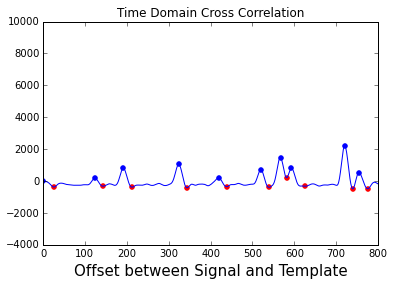

In [5]:
template_list = [0,0.25,0.75,1.75,2.5,6,7.75,9.25,10.25,10.75,11.25,11.5,11.25,10.75,10.25,9.25,7.75,6,2.5,1.75,0.75,0.25,0]

ax = plt.figure().add_subplot(111)
zero_convoluted_data = list(photons)
zero_noised_signal =   template_list

a = zero_convoluted_data
v = zero_noised_signal


#a = (a - np.average(a))/(np.std(a) * len(a))
#v = (v - np.average(v))/(np.std(v))


correlated_data = signal.correlate(a, v, mode = 'full' )
#correlated_data_1 = signal.correlate(a, v1, mode = 'full')
ax.plot(correlated_data, label = "correlated")
#ax.plot(a * 100, label = "original")
plt.xlabel('Offset between Signal and Template', fontsize = 15)
maxtab, mintab = peakdet(correlated_data,328)
ax.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue', label = "Peaks")
ax.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red', label = "Valleys")


ax.set_xlim(0, 800)
ax.set_title("Time Domain Cross Correlation")
plt.show()

I am plotting a histogram to make sure that the threshold value could be extracted. 

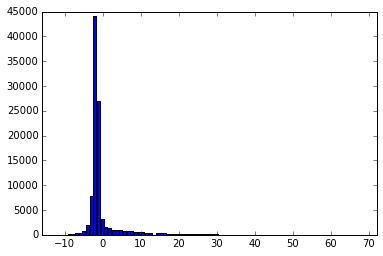

In [6]:
hist, bin_edges = np.histogram(photons, bins = 91)
plt.bar(bin_edges[:-1], hist)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()   

The clean algorithm is the algorithm used in the GUI. It uses the following portions of code.

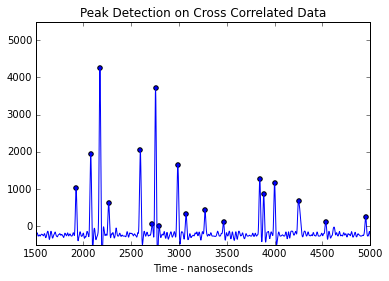

In [12]:

bin_count = 1
temp_data = []
while 0 not in temp_data:
    temp_data, x = np.histogram(correlated_data, bins = bin_count)
    bin_count += 1
    
hist, bin_edges = np.histogram(correlated_data, bins = bin_count)
    
total_count = sum(hist)
temp_sum = 0
threshold_value = 0

for i in range(0, len(hist)):
    temp_sum += hist[i]
    if temp_sum >= total_count * 0.90 and bin_edges[i] > 0:
        threshold_value = i
        break
            
threshold_value = bin_edges[threshold_value]
    
temp_peak_times = threshold_algorithm(threshold_value,correlated_data)
temp_peak_values = threshold_algorithm_1(threshold_value, correlated_data)

ax = plt.figure().add_subplot(111)
ax.plot(correlated_data)
ax.scatter(temp_peak_times, temp_peak_values)

ax.set_title("Peak Detection on Cross Correlated Data")
ax.set_xlabel("Time - nanoseconds")
ax.set_xlim(1500, 5000)
ax.set_ylim(-500, 5500)
plt.show()

The following code turns the peaks detected from the algorithm and creates a mean-variance graph to, again, confirm its poisson nature.

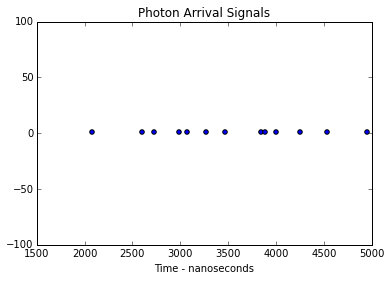

In [7]:
bin_count = 1
temp_data = []
while 0 not in temp_data:
    temp_data, x = np.histogram(correlated_data, bins = bin_count)
    bin_count += 1
    
hist, bin_edges = np.histogram(correlated_data, bins = bin_count)
    
total_count = sum(hist)
temp_sum = 0
threshold_value = 0

for i in range(0, len(hist)):
    temp_sum += hist[i]
    if temp_sum >= total_count * 0.90 and bin_edges[i] > 0:
        threshold_value = i
        break
            
threshold_value = bin_edges[threshold_value]
    
temp_peak_times = threshold_algorithm(threshold_value,correlated_data)
temp_peak_values = threshold_algorithm_1(threshold_value, correlated_data)

peak_values = []
peak_times = []
reached_peakhigh = False
#print temp_peak_times[0:200], temp_peak_values[0:200]
#print "__________________________________________"
for c in range(0, len(temp_peak_values)):
    if reached_peakhigh and temp_peak_values[c] < 1200:
        reached_peakhigh = False
        continue
    if temp_peak_values[c] < 2300:
        peak_values.append(temp_peak_values[c])
        peak_times.append(temp_peak_times[c])
    if temp_peak_values[c] >= 2500:
        reached_peakhigh = True

        
final_peak_times = peak_times
final_peak_values = []
    
for peak in peak_values:
    final_peak_values.append(1)
    
ax = plt.figure().add_subplot(111)
ax.scatter(final_peak_times, final_peak_values)
ax.set_xlabel("Time - nanoseconds")
ax.set_title("Photon Arrival Signals")
ax.set_xlim(1500, 5000)
ax.set_ylim(-100, 100)
plt.show()

In [37]:
'''
the data must be correlated with the template_list
'''

def threshold_histogram(data):
    global c
    bin_count = 1
    temp_data = []
    while 0 not in temp_data:
        temp_data, x = np.histogram(data, bins = bin_count)
        bin_count += 1
    
    hist, bin_edges = np.histogram(data, bins = bin_count)
    
    total_count = sum(hist)
    temp_sum = 0
    threshold_value = 0
    
    for i in range(0, len(hist)):
        temp_sum += hist[i]
        if temp_sum >= total_count * 0.90 and bin_edges[i] > 0:
            threshold_value = i
            break
            
    threshold_value = bin_edges[threshold_value]
    
    temp_peak_times = threshold_algorithm(threshold_value,data)
    temp_peak_values = threshold_algorithm_1(threshold_value, data)
    peak_values = []
    peak_times = []
    reached_peakhigh = False
    #print temp_peak_times[0:200], temp_peak_values[0:200]
    #print "__________________________________________"
    for c in range(0, len(temp_peak_values)):
        if reached_peakhigh and temp_peak_values[c] < 1200:
            reached_peakhigh = False
            continue
        if temp_peak_values[c] < 2300:
            peak_values.append(temp_peak_values[c])
            peak_times.append(temp_peak_times[c])
        if temp_peak_values[c] >= 2500:
            reached_peakhigh = True
            

    final_peak_times = peak_times
    final_peak_values = []
    
    for peak in peak_values:
        final_peak_values.append(1)
    
    return final_peak_times                                                                
    '''
    ax = plt.figure().add_subplot(111)
    #ax.plot(data)
    ax.scatter(final_peak_times, final_peak_values)
    
    ax.set_xlim(0, 800)
    ax.set_xlim(-100, 2500)
    plt.show()
    '''

In [52]:
js.threshold_histogram(correlated_data)

Slope: 0.972509719419
R-Squared: 0.997758013927
Error Bars: [0, 0.3907326451680227, 0.19283153269110317, 0.1219398758951859, 0.089988888202933145, 0.072303360917733275, 0.061759389749431792, 0.053601270599795824, 0.046634214907082971, 0.039473072553199144, 0.035909218872038969]


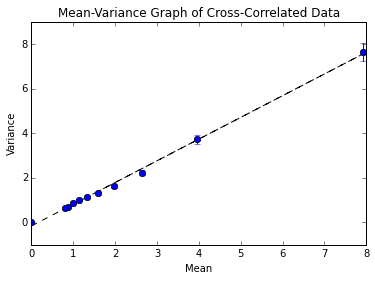

In [56]:
final_peak_times = js.threshold_histogram(correlated_data)
#the mean_variance_graph function does not plot the graph for you (thats why matplotlib should be locally imported
#rather, it returns the values necessary to plot it
mean, variance, error = js.mean_variance_graph(final_peak_times)
mean.insert(0, 0)
variance.insert(0, 0)
error.insert(0,0)
ax = plt.figure().add_subplot(111)
m, b = np.polyfit(mean, variance, 1)
fit= np.polyfit(mean,variance,1)
fit_fn = np.poly1d(fit) 

plt.plot(mean,variance, 'yo', mean, fit_fn(mean) , '--k')
ax.set_xlabel("Mean")
ax.set_ylabel("Variance")
ax.set_title("Mean-Variance Graph of Cross-Correlated Data")
plt.errorbar(mean, variance, yerr= error, fmt = 'o')

print "Slope: " + str(m)
print "R-Squared: " + str(js.rsquared(mean, variance))
print "Error Bars: " + str(error)
plt.show()